In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import pandas as pd
from types import new_class
import warnings

# Desativar mensagens de aviso de depreciação
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
%cd /content/drive/MyDrive/Colab Notebooks/Mestrado/Final

/content/drive/MyDrive/Colab Notebooks/Mestrado/Final


In [18]:
def plot_sim_history(sim_history_x1, sim_history_x2):
  plt.figure(figsize=(16, 10))  # Define o tamanho do gráfico

  plt.subplot(3, 1, 1)
  plt.plot(sim_history_x1['x'], label='x1')
  plt.plot(sim_history_x1['ref'], label='ref1', linestyle=':')
  plt.plot(sim_history_x2['x'], label='x2')
  plt.plot(sim_history_x2['ref'], label='ref2', linestyle=':')
  plt.xlabel("Steps/Time(s)")
  plt.ylabel("Level(m)")
  plt.title('Gráfico de Controle Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.subplot(3, 1, 2)
  plt.plot(sim_history_x1['qe'], label='qe')
  plt.plot(sim_history_x1['qs'], label='qs')
  plt.ylabel("(m^3/s)")
  plt.title('Gráfico de Sinal Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  plt.subplot(3, 1, 3)
  plt.plot(sim_history_x1['erro'], label='erro')
  plt.ylabel("erro (m)")
  plt.title('Gráfico de Erro Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.show()

In [19]:
class TankEnvirolment:
    def __init__(self, initial_x1, initial_x2, initial_qe, initial_qs, initial_vc, ref1, ref2):

        self.ref1 = ref1
        self.ref2 = ref2

        self.initial_x1 = initial_x1
        self.initial_x2 = initial_x2

        self.initial_qe = initial_qe
        self.initial_qs = initial_qs
        self.initial_vc = initial_vc

        self.x1 = self.initial_x1
        self.x2 = self.initial_x2

        self.qe = self.initial_qe
        self.vc = self.initial_vc
        self.qc = 0

        self.last_x1 = self.x1
        self.last_x2 = self.x2

        self.last_ref1 = self.ref1
        self.last_ref2 = self.ref2

        # Process Const
        self.area = 16
        self.max_level = 12
        self.k1 = 2
        self.k2 = 1
        self.ts = 1

        self.state_table = list(np.round(np.arange(-self.max_level, self.max_level + 0.01, 0.01), 2))

        self.action_table = list(np.round(np.arange(0, 1.1, 0.01), 2))

        self.num_states = len(self.state_table)
        self.num_actions = len(self.action_table)

        self.reset();

    def System_To_RL_State(self):

        state_x1 = np.round(self.x1 - self.ref1, 2)
        state_x1 = np.clip(state_x1, -self.max_level, self.max_level, out=None)
        state_index_x1 = self.state_table.index(state_x1)

        state_x2 = np.round(self.x2 - self.ref2, 2)
        state_x2 = np.clip(state_x2, -self.max_level, self.max_level, out=None)
        state_index_x2 = self.state_table.index(state_x2)

        return state_index_x1, state_index_x2

    def step(self, a1, a2):

        self.last_x1 = self.x1
        self.last_x2 = self.x2

        self.last_ref1 = self.ref1
        self.last_ref2 = self.ref2

        # Getting the Actual action
        self.qe, self.vc = self.get_action(a1, a2)

        # Finding the steady state of the system corresponding to the action 'A'
        self.x1, self.qc = self.tank_rk(self.x1, self.qe, self.vc, self.k1, self.ts)
        self.x2, self.qs = self.tank_rk(self.x2, self.qc, 100    , self.k2, self.ts)

        reward1, reward2 = self.reward_calc()

        next_s1, next_s2 = self.System_To_RL_State()

        if self.state_table[next_s1] == 0 and self.state_table[next_s2] == 0:
            done = True
        else:
            done = False

        return next_s1, next_s2, reward1, reward2, done


    def get_action(self, a1, a2):

        qe = 4.0 * self.action_table[a1]
        qe = max(0, qe)
        qe = min(4, qe)

        vc = self.action_table[a2] * 100

        return qe, vc

    def reward_calc(self):
        if self.ref1 != self.last_ref1:
          reward1 = 0;
        else:
          erro = abs(self.ref1 - self.x1)
          if erro < 0.1:
            reward1 = (0.1 - erro) * 10
          else:
            reward1 = 0

        if self.ref2 != self.last_ref2:
          reward2 = 0;
        else:
          erro = abs(self.ref1 - self.x1)
          if erro < 0.1:
            reward2 = (0.1 - erro) * 10
          else:
            reward2 = 0

        #reward = abs(self.last_ref - self.last_x) - abs(self.ref - self.x)

        #if dif == 0 and abs(self.x - self.ref) > 0:
        #  dif = -0.1;

        #return dif
        #reward = -abs(self.ref - self.x)


        #dif = np.round(self.ref - self.x, 1)
        #if dif == 0:
        #    reward = 100
        #else:
        #    reward = -np.square(dif)*100

        #reward = abs((self.ref - self.x) - (self.last_ref - self.last_x)) / 2;

        #if abs(self.ref - self.x) <= abs(self.last_ref - self.last_x):
        #  reward = 1
        #else:
        #  reward = -1

        return reward1, reward2

    def tank_xdot(self, x, qe, valve=100, valve_k = 1):
      if x >= 0:
        qs = valve_k * (valve / 100) * math.sqrt(x)
      else:
        qs = 0
      xd = (qe - qs) / self.area
      return xd, qs

    def tank_rk(self, x0, qe, valve=100, valve_k = 1, t=0.2):
      a=x0
      b=qe
      c=valve
      #call 1
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      savex0 = x0;
      phi = xd;
      x0 = savex0 + 0.5 * t * xd;

      #call two
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      phi = phi + 2 * xd;
      x0 = savex0 + 0.5 * t * xd;

      #call three
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      phi = phi + 2 * xd;
      x0 = savex0 + t * xd;

      #call four
      xd, qs = self.tank_xdot(x0, qe, valve, valve_k);
      x = savex0 + (phi + xd) * t / 6;

      if x < 0:
        x = 0

      if x > self.max_level:
        x = self.max_level

      if np.isnan(x):
        x = 0

      if np.isnan(qs):
        qs = 0

      return x, qs;

    def reset(self):
        self.x1 = self.initial_x1
        self.x2 = self.initial_x2

        self.qe = self.initial_qe
        self.vc = self.initial_vc
        self.qc = 0

        self.last_x1 = self.x1
        self.last_x2 = self.x2

        self.last_ref1 = self.ref1
        self.last_ref2 = self.ref2
#env = TankEnvirolment([0,0], 0, 0, 0, [2,2])
#env.num_states, env.num_actions
#s = env.System_To_RL_State([0.1,0])
#env.step(10)

In [20]:
class TankAgent:
    def __init__(self, alpha = 0.1, gamma = 0.9, epsilon = 1, num_states = None, num_actions = None):
        self.alpha = alpha;
        self.gamma = gamma;
        self.epsilon = epsilon;

        self.num_states = num_states
        self.num_actions = num_actions

        self.q_table_x1 = self.init_q_table();
        self.q_table_x2 = self.init_q_table();

    def e_greedy_policy(self, s1, s2):
        """
        This function performs the epsilon greedy action selection
        :param no_a: No. of actions available
        :param e: Exploration parameter
        :param q: Action value function for the current state
        :return: epsilon greedy action
        """
        if np.random.rand() < self.epsilon:
            a1 = np.random.randint(0, self.num_actions)
            a2 = np.random.randint(0, self.num_actions)
        else:
            a1 = np.argmax(self.q_table_x1[s1,:])
            a2 = np.argmax(self.q_table_x1[s2,:])

        return a1, a2

    def init_q_table(self, type="zeros"):
        '''
        This function initializes the table of Action-value function for each state and action.
        :param s: No. of states
        :param a: NO. of possible action available
        :param type: "zeros", "Ones", "Random"
        :return: s x a dimensional matrix for action value function Q(s, a).
        '''
        if type == "ones":
            q = np.ones((self.num_states, self.num_actions))

        if type == "zeros":
            q = np.zeros((self.num_states, self.num_actions))

        if type == "random":
            q = np.random.random((self.num_states, self.num_actions))

        return q

    def update_q_table_x1(self, s, a, reward, next_s):
        '''
        Q(s, a) = Q(s, a) + α * [R + γ * max(Q(s', a')) - Q(s, a)]

        Q(s, a) é o valor atual da tabela Q para o par estado-ação.
        α (alfa) é a taxa de aprendizado, que controla o quão rápido os valores da tabela Q são atualizados.
        R é a recompensa imediata recebida após a ação.
        γ (gama) é o fator de desconto que pondera a importância das recompensas futuras.
        max(Q(s', a')) é a estimativa do valor futuro do próximo estado s' e ação a'.
        '''
        max_a = np.argmax(self.q_table_x1[next_s,:])
        self.q_table_x1[s, a] += self.alpha * (reward + self.gamma * self.q_table_x1[next_s, max_a] - self.q_table_x1[s, a])

    def update_q_table_x2(self, s, a, reward, next_s):
        max_a = np.argmax(self.q_table_x2[next_s,:])
        self.q_table_x2[s, a] += self.alpha * (reward + self.gamma * self.q_table_x2[next_s, max_a] - self.q_table_x2[s, a])

    def save_q_table(self, name = 'Q_Mattrix'):
      np.savetxt(name+'_x1', self.q_table_x1)
      np.savetxt(name+'_x2', self.q_table_x2)

    def load_q_table(self, name = 'Q_Mattrix'):
      self.q_table_x1 = np.loadtxt(name+'_x1')
      self.q_table_x2 = np.loadtxt(name+'_x2')

In [28]:
####################### Q -Learning #########################################
def train(alpha = 0.1, gamma = 0.9, epsilon = 1, episodes = 1000, max_step = 500):
    '''
    Training of the level controller in the RL - Environment by TD-Q learning
    '''

    train_history_columns = ["qe", "qs", "x", "ref", "erro", "s", "value_s", "a", "value_a", "next_s", "value_next_s", "reward", "done"]
    train_history = np.zeros((0,len(train_history_columns))) # Temp Calc
    #train_history = [[] for _ in range(len(train_history_columns))]
    train_history = []

    # Initializing TankLevel Environment and Agent
    env = TankEnvirolment(initial_x1=0, initial_x2=0, initial_qe=2, initial_qs=2, initial_vc=100, ref1=6, ref2=6)
    agent = TankAgent(alpha = alpha, gamma = gamma, epsilon = epsilon, num_states = env.num_states, num_actions = env.num_actions)

    # Variables for recording the progress of the training
    episode_reward = []
    state = []
    set_point = []

    # Episode Loop
    for i in tqdm(range(episodes)):
    #for i in range(episodes):
        env.reset()
        t = 0
        total_reward = 0

        # Changing the Set point every 1000 episode
        #if i>0 and i % 1000 == 0:
        #    env.ref = np.random.choice(np.arange(0, 13, 0.5))

        # Changing the exploration parameter every 500 episode
        if i>0 and i% 500 == 0:
            agent.epsilon = max(0.1, epsilon - 0.01)

        # RL Environment state
        #s = env.System_To_RL_State(env.x)

        # e - greedy action selection
        #print(n_a)
        #a = agent.e_greedy_policy(s)

        # Step loop
        while t < max_step:

            s1, s2 = env.System_To_RL_State()

            a1, a2 = agent.e_greedy_policy(s1, s2)

            # Taking a step in the environment
            next_s1, next_s2, reward1, reward2, done = env.step(a1, a2)

            # Action selection for the next state according to behaviour policy(i.e. e - greedy)
            #next_a = agent.e_greedy_policy(s)

            # finding the action with maximum return
            #total_reward += reward

            # Action-value function update
            agent.update_q_table_x1(s1, a1, reward1, next_s1)
            agent.update_q_table_x2(s2, a2, reward2, next_s2)

            # Recording the state and set point
            #state.append(env.x)
            #set_point.append(env.ref)

            #train_history = np.vstack((train_history, (env.qe, env.qs, env.x, env.ref, env.x-env.ref, env.state_table[s], env.action_table[a], env.state_table[next_s], env.action_table[next_a], reward, done, env.action_table[a])))
            #train_history.append([env.qe, env.qs, env.x, env.ref, env.x-env.ref, s, env.state_table[s], a, env.action_table[a], next_s, env.state_table[next_s], reward, done])

            t += 1
            #s, a = next_s, next_a

            if done:
                episode_reward.append(total_reward)
                #print(f"success in episode: {i} step: {t}")
                #break
                #episode_reward.append(total_reward)

                #plt.plot(episode_reward)
                #plt.show()
    agent.save_q_table()
    train_history=pd.DataFrame(data=train_history, columns=train_history_columns)
    #train_history=pd.DataFrame(train_history, columns=train_history_columns)
    return train_history, agent.q_table_x1, agent.q_table_x2, env.state_table, env.action_table
train_history, q_table_x1, q_table_x2, states_table, action_table = train(alpha = 0.1, gamma = 0.9, epsilon = 1, episodes = 1000, max_step = 500)
train_history

100%|██████████| 1000/1000 [02:11<00:00,  7.61it/s]


,qe,qs,x,ref,erro,s,value_s,a,value_a,next_s,value_next_s,reward,done


100%|██████████| 1000/1000 [00:00<00:00, 4300.02it/s]


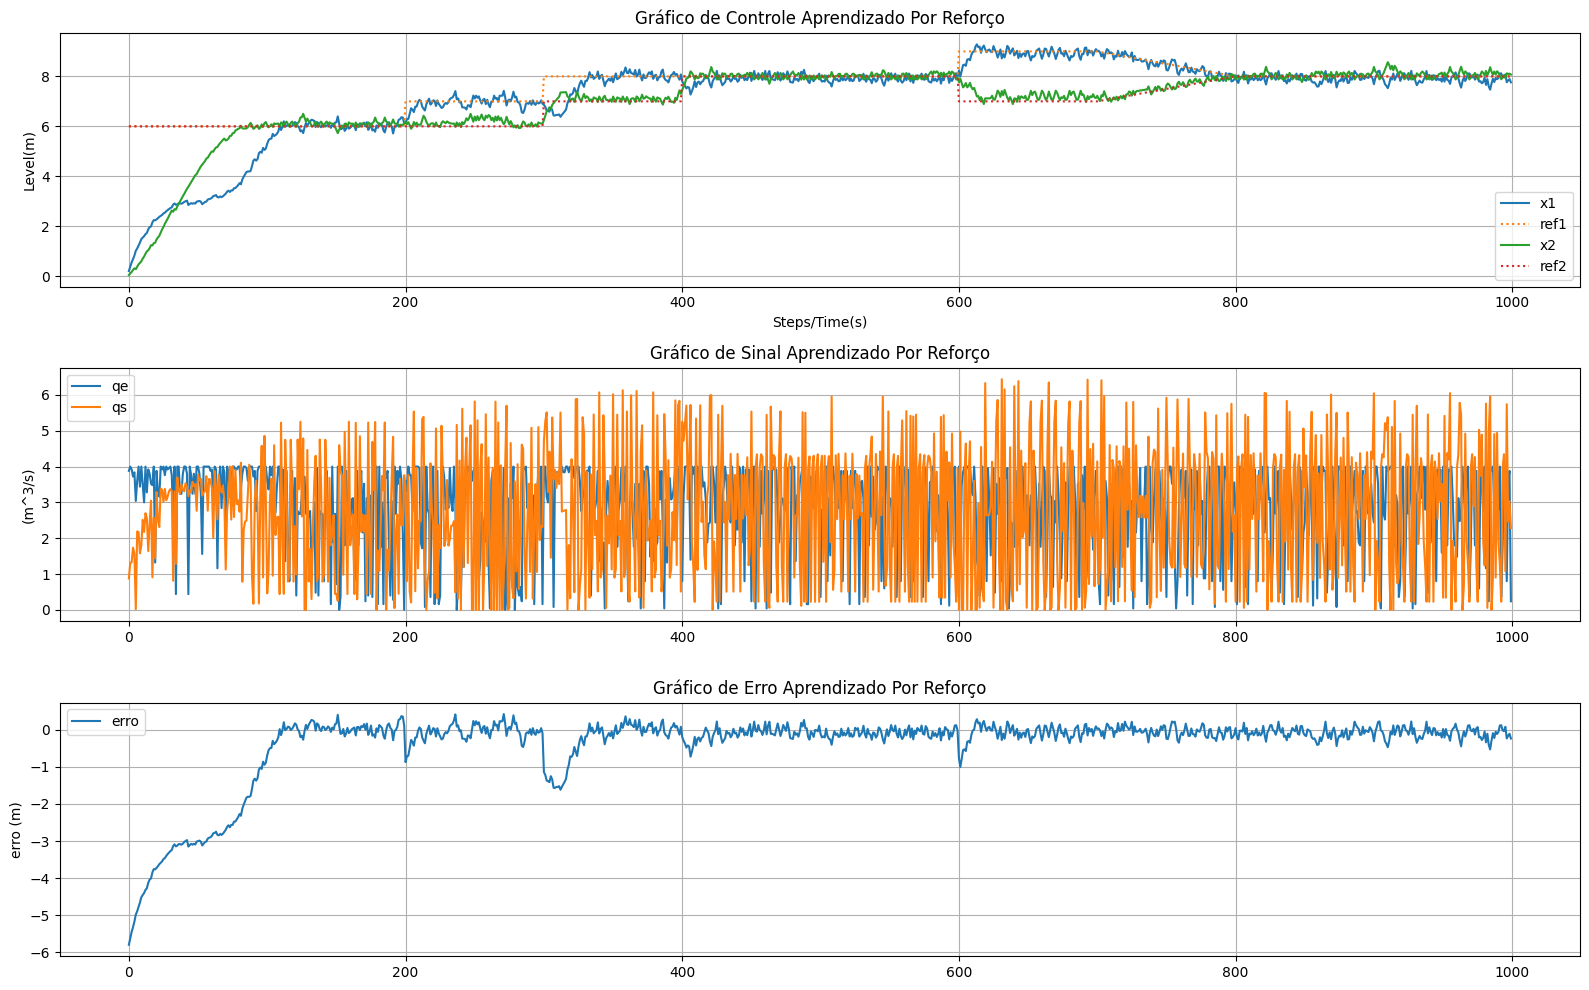

In [29]:
#Simulation Parameters
num_sim = 1000
ref1 = 6
ref2 = 6

env = TankEnvirolment(initial_x1=0, initial_x2=0, initial_qe=2, initial_qs=2, initial_vc=100, ref1=ref1, ref2=ref2)
agent = TankAgent(alpha = 0.1, gamma = 0.9, epsilon = 0.1, num_states = env.num_states, num_actions = env.num_actions)
agent.load_q_table()

#Set initial conditions
sim_history_columns = ["qe", "qs", "x", "ref", "erro", "s", "value_s" , "a", "value_a", "next_s", "value_next_s", "reward", "done"]
sim_history_x1 = np.zeros((0,len(sim_history_columns))) # Temp Calc
sim_history_x2 = np.zeros((0,len(sim_history_columns))) # Temp Calc

sim_history_x1 = []
sim_history_x2 = []

valve = 100;

#Start Simulation
for run in tqdm(range(num_sim)):

    if run == 200:
      ref1 += 1;

    if run == 300:
      ref1 += 1;
      ref2 += 1;

    if run == 400:
      ref2 += 1;

    if run == 600:
      ref1 += 1;
      ref2 -= 1;

    if 700 < run <= 800:
      ref1 -= 1/100;
      ref2 += 1/100;

    env.ref1 = ref1
    env.ref2 = ref2

    s1, s2 = env.System_To_RL_State()
    a1, a2 = agent.e_greedy_policy(s1,s2)

    next_s1, next_s2, reward1, reward2, done = env.step(a1, a2)

    agent.update_q_table_x1(s1, a1, reward1, next_s1)
    agent.update_q_table_x2(s2, a2, reward2, next_s2)

    sim_history_x1.append([env.qe, env.qc, env.x1, env.ref1, env.x1-env.ref1, s1, env.state_table[s1], a1, env.action_table[a1], next_s1, env.state_table[next_s1], reward1, done])
    sim_history_x2.append([env.qc, env.qs, env.x2, env.ref2, env.x2-env.ref2, s2, env.state_table[s2], a2, env.action_table[a2], next_s2, env.state_table[next_s2], reward2, done])

sim_history_x1=pd.DataFrame(data=sim_history_x1, columns=sim_history_columns)
sim_history_x2=pd.DataFrame(data=sim_history_x2, columns=sim_history_columns)
sim_history_x1.to_csv('Tank-Level-Control-with-Reinforcement-Learning-2-Sim_X1.csv', index=False)
sim_history_x2.to_csv('Tank-Level-Control-with-Reinforcement-Learning-2-Sim_X2.csv', index=False)
plot_sim_history(sim_history_x1, sim_history_x2)

In [30]:
sim_history_x1

,qe,qs,x,ref,erro,s,value_s,a,value_a,next_s,value_next_s,reward,done
0,3.88,0.876508,0.206506,6.0,-5.793494,600,-6.00,97,0.97,621,-5.79,0.000000,False
1,4.00,1.314612,0.384536,6.0,-5.615464,621,-5.79,105,1.05,638,-5.62,0.000000,False
2,3.92,1.324114,0.553363,6.0,-5.446637,638,-5.62,98,0.98,655,-5.45,0.000000,False
3,3.72,1.735127,0.682655,6.0,-5.317345,655,-5.45,93,0.93,668,-5.32,0.000000,False
4,3.84,1.566234,0.829180,6.0,-5.170820,668,-5.32,96,0.96,683,-5.17,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.96,1.079997,8.077518,8.0,0.077518,1196,-0.04,74,0.74,1208,0.08,0.224824,False
996,0.80,5.740401,7.765172,8.0,-0.234828,1208,0.08,20,0.20,1177,-0.23,0.000000,False
997,3.60,2.463459,7.836556,8.0,-0.163444,1177,-0.23,90,0.90,1184,-0.16,0.000000,False
998,3.88,3.033585,7.889777,8.0,-0.110223,1184,-0.16,97,0.97,1189,-0.11,0.000000,False


In [24]:
sim_history_x2

,qe,qs,x,ref,erro,s,value_s,a,value_a,next_s,value_next_s,reward,done
0,0.933036,0.220609,0.049244,2.0,-1.950756,1000,-2.00,102,1.02,1005,-1.95,0.000000,False
1,1.333744,0.338704,0.114765,2.0,-1.885235,1005,-1.95,107,1.07,1011,-1.89,0.000000,False
2,1.555445,0.433221,0.187695,2.0,-1.812305,1011,-1.89,105,1.05,1019,-1.81,0.000000,False
3,1.735331,0.516117,0.266382,2.0,-1.733618,1019,-1.81,104,1.04,1027,-1.73,0.000000,False
4,1.731862,0.583271,0.340205,2.0,-1.659795,1027,-1.73,98,0.98,1034,-1.66,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.282456,2.007330,4.029378,4.0,0.029378,1214,0.14,7,0.07,1203,0.03,0.295177,False
996,2.011732,2.007399,4.029651,4.0,0.029651,1203,0.03,50,0.50,1203,0.03,0.529322,False
997,1.980482,2.006983,4.027982,4.0,0.027982,1203,0.03,50,0.50,1203,0.03,0.223111,False
998,2.011852,2.007059,4.028284,4.0,0.028284,1203,0.03,50,0.50,1203,0.03,0.524545,False


In [25]:
s = env.System_To_RL_State(0)
agent.q_table[s,:]
#env.state_table[80]

s = 1223

a = agent.e_greedy_policy(s)

#s = 119
#a = np.argmax(agent.q_table[s,:])

[s, a, env.state_table[s], env.action_table[a]]

agent.q_table[s,:]

TypeError: TankEnvirolment.System_To_RL_State() takes 1 positional argument but 2 were given

In [ ]:
num_inputs = 2
discrete_state = 0.0
state = [1.1,12]
for i in range(num_inputs):
  discrete_state += state[i] * (2**i)
discrete_state

In [ ]:
agent.q_table[119,:]

In [ ]:
agent.q_table[s,:]